In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## Loading the spatial tessellation
Taking the shapefile of the 155 [urban areas](https://it.wikipedia.org/wiki/Zone_urbanistiche_di_Roma).

In [2]:
PATH_TO_DATA = '../data/external/ISTAT_zone_urbanistiche_Roma/'

gdf_rome = gpd.read_file(PATH_TO_DATA + 'Roma_Zone_Urbanistiche_WGS84.shp')
print(gdf_rome.shape)
print(gdf_rome.crs)
gdf_rome.head()

(155, 6)
epsg:32632


,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry
0,58091.0,10l,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4..."
1,58091.0,10a,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4..."
2,58091.0,10b,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4..."
3,58091.0,10c,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4..."
4,58091.0,10d,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4..."


In [3]:
# CODZU is a unique ID of each urban area
len(gdf_rome.COD_Z_URB)

# note: the total area of each zone ('SHAPE_Area') is in m^2

155

## Covariates

### Point-features
These are features like:
- traffic lights
- POIs

from which we will compute a measure of density for each of the urban areas.

#### Traffic lights

In [13]:
URL_TO_DATA = 'https://www.comune.roma.it/TERRITORIO/geoserver/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=dit:Semafori&SRSNAME=EPSG:6708&outputFormat=SHAPE-ZIP'

gdf_tl = gpd.read_file(URL_TO_DATA)
print(gdf_tl.shape)
print(gdf_tl.crs)
gdf_tl.head()

(1541, 9)
epsg:6708


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (294246.969 4642743.354)
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (293526.621 4642757.220)
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (295076.397 4642760.961)
3,17058,APL,Via Cipro,None,P.le degli Eroi,Ospedale Oftalmico,I,None,POINT (288360.167 4642762.393)
4,17025,V,Viale Giulio Cesare,None,Via Candia,Via Leone IV,I,Sigma Plus,POINT (288962.732 4642769.784)


In [14]:
# reprojecting onto epsg:32633
gdf_tl_proj = gdf_tl.to_crs(gdf_rome.crs)

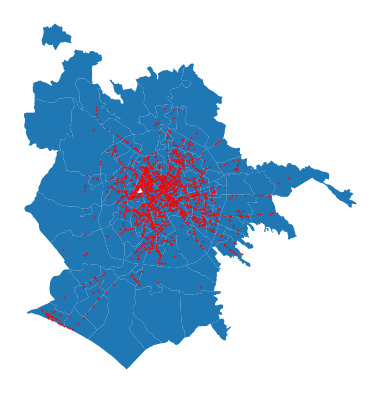

In [15]:
ax = gdf_rome.plot(figsize=(7,7))
gdf_tl_proj.plot(ax=ax, color='red', markersize=0.8)
ax.set_axis_off()

In [16]:
gdf_tl_join = gpd.sjoin(gdf_tl_proj, gdf_rome, how="inner", op='intersects')
print(gdf_tl_join.shape)
gdf_tl_join.head()

(1539, 15)


/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry,index_right,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (791880.520 4645758.471),106,58091.0,3a,Nomentano,9426.788621,2.930423e+06
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (791160.589 4645721.909),106,58091.0,3a,Nomentano,9426.788621,2.930423e+06
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (792707.126 4645834.077),106,58091.0,3a,Nomentano,9426.788621,2.930423e+06
74,03004,V,Via Nomentana,None,Viale Pola,Via Bosio,II,Omnia,POINT (791337.359 4646555.570),106,58091.0,3a,Nomentano,9426.788621,2.930423e+06
82,03064,CL,Circonvallazione Nomentana,328,Via Salento,Tang. Est direzione Foro Italico,II,None,POINT (792483.729 4646697.475),106,58091.0,3a,Nomentano,9426.788621,2.930423e+06


In [17]:
tl_number = gdf_tl_join['COD_Z_URB'].value_counts().reset_index()
tl_number.columns = ['COD_Z_URB', 'n_traffic_lights']

gdf_rome = gdf_rome.merge(tl_number, how='left', on='COD_Z_URB')
print(gdf_rome.shape)
gdf_rome.head()

(155, 7)


,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights
0,58091.0,10l,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0
1,58091.0,10a,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0
2,58091.0,10b,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0
3,58091.0,10c,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0
4,58091.0,10d,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0


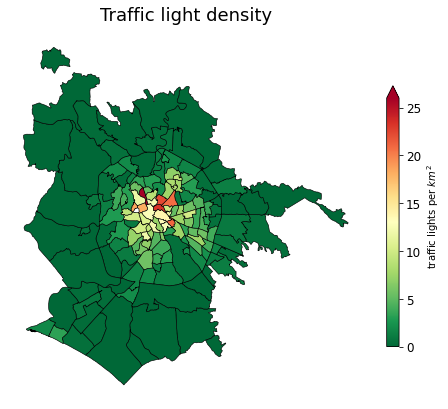

In [69]:
# NaNs are areas where there are zero traffic lights
gdf_rome['n_traffic_lights'] = gdf_rome['n_traffic_lights'].fillna(0)

# compute traffic light density for each area:
gdf_rome['density_traffic_lights'] = gdf_rome['n_traffic_lights'] / (gdf_rome['SHAPE_Area']*1e-6)

fig, ax = plt.subplots(1, figsize=(8,8))
gdf_rome.plot(ax=ax, column='density_traffic_lights', cmap='RdYlGn_r', edgecolor='black', linewidth=0.6,
              legend=True, legend_kwds={'label': r"traffic lights per $km^2$", 
                                        'orientation': "vertical", 
                                        'shrink':0.6, 'extend':'max'})
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=12)

ax.set_title('Traffic light density', fontsize=18, pad=10)
ax.set_axis_off()

#fig = ax.get_figure()
#fig.savefig('rome_traffic_light_density.png', dpi=300)

#### Shops

The original .csv can be found at https://dati.comune.roma.it/catalog/dataset/d148/resource/da49d933-c541-4466-920e-2cc24aec0258.

We identified, when possible, the location of each shop from its address, and added it to the .csv as two new columns _lat, lng_. Here we load and use this last new file.

In [34]:
URL_TO_DATA = 'https://www.dropbox.com/s/8yyv0idtca3t8cj/rome_shops_with_location.csv?dl=1'

df_sh = pd.read_csv(URL_TO_DATA)
print(df_sh.shape)
df_sh.head()

(130244, 18)


,NUMEROESERCIZIO,DATAINIZIO,CODICEVIA,DESCRIZIONEVIA,CIVICO,ESPCIVICO,MUNICIPIO,SUPERFICIETOTALE,CODICEMACROATTIVITA,DESCRIZIONEMACROATTIVITA,TIPOATTIVITA,DESCRIZIONEATTIVITA,CODICESPECIALIZZAZIONE,DESCRIZIONESPECIALIZZAZIONE,SUPERFICIEALIMENTARE,SUPERFICIENONALIMENTARE,lat,lng
0,957,20020328,31130.0,VIA DEI CORONARI,37.0,NaN,MUN. I,45,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,36.0,"MOBILI, CASALINGHI E ARTICOLI DI ILLUMINAZIONE",NaN,NON_ALIMENTARE,41.900459,12.470566
1,956,20020314,16160.0,VIA DEL BOSCHETTO,46.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,21.0,"ARTICOLI DI SECONDA MANO (LIBRI, MOBILI, INDUM...",NaN,NON_ALIMENTARE,41.897572,12.490340
2,959,20020228,99862.0,VIA DELLA VII COORTE,5.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,3.0,"BEVANDE (VINI, OLI BIRRA E ALTRE)",ALIMENTARE,NaN,41.888709,12.474520
3,961,20020409,56364.0,VIA GIUSEPPE ROMITA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,27.0,DISTRIBUTORI DI CARBURANTI,NaN,NON_ALIMENTARE,41.903308,12.496302
4,962,20020415,14311.0,VIA BELSIANA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,36.0,"MOBILI, CASALINGHI E ARTICOLI DI ILLUMINAZIONE",NaN,NON_ALIMENTARE,41.905523,12.479411


In [35]:
# dropping one row with a completely wrong location (lng = -75.592625)
df_sh.drop(79789, axis=0, inplace=True)

In [36]:
n_shops_no_loc = len(df_sh[(df_sh.lat.isnull()==True) & (df_sh.lng.isnull()==True)])

print('There are %s shops with no identified location (%.1f%%).' %(n_shops_no_loc, n_shops_no_loc/len(df_sh)*100))

There are 801 shops with no identified location (0.6%).


In [37]:
# creating the gdf
gdf_sh = gpd.GeoDataFrame(df_sh, geometry=gpd.points_from_xy(df_sh.lng, df_sh.lat), crs='epsg:4326')

# reprojecting onto epsg:32633
gdf_sh_proj = gdf_sh.to_crs(gdf_rome.crs)

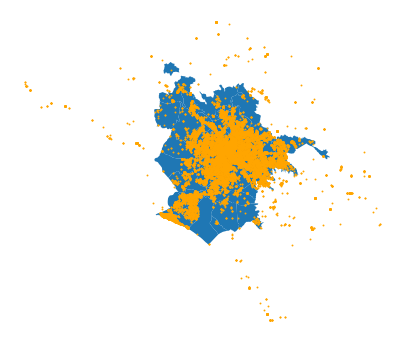

In [38]:
ax = gdf_rome.plot(figsize=(7,7))
gdf_sh_proj.plot(ax=ax, color='orange', markersize=0.8)
ax.set_axis_off()

In [39]:
# taking only the shops inside Rome
gdf_sh_join = gpd.sjoin(gdf_sh_proj, gdf_rome, how="inner", op='intersects')
print(gdf_sh_join.shape)
gdf_sh_join.head()

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


(127868, 27)


,NUMEROESERCIZIO,DATAINIZIO,CODICEVIA,DESCRIZIONEVIA,CIVICO,ESPCIVICO,MUNICIPIO,SUPERFICIETOTALE,CODICEMACROATTIVITA,DESCRIZIONEMACROATTIVITA,...,lng,geometry,index_right,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights
0,957,20020328,31130.0,VIA DEI CORONARI,37.0,NaN,MUN. I,45,CSF,COMMERCIO IN SEDE FISSA,...,12.470566,POINT (787890.821 4644551.237),75,58091.0,1a,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
4,962,20020415,14311.0,VIA BELSIANA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,...,12.479411,POINT (788601.757 4645143.271),75,58091.0,1a,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
7,965,20020221,68750.0,VIA MARGUTTA,1.0,B,MUN. I,31,CSF,COMMERCIO IN SEDE FISSA,...,12.478311,POINT (788491.416 4645610.761),75,58091.0,1a,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
19,991,20030515,111001.0,VIA DEL VANTAGGIO,41.0,A,MUN. I,24,CSF,COMMERCIO IN SEDE FISSA,...,12.476470,POINT (788344.232 4645468.905),75,58091.0,1a,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257
20,992,20030411,81319.0,LARGO DEL PALLARO,18.0,NaN,MUN. I,31,CSF,COMMERCIO IN SEDE FISSA,...,12.473853,POINT (788185.687 4644015.726),75,58091.0,1a,Centro Storico,9484.910322,3.204813e+06,41.0,12.793257


In [40]:
shops_number = gdf_sh_join['COD_Z_URB'].value_counts().reset_index()
shops_number.columns = ['COD_Z_URB', 'n_shops']

gdf_rome = gdf_rome.merge(shops_number, how='left', on='COD_Z_URB')
print(gdf_rome.shape)
gdf_rome.head()

(155, 9)


,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops
0,58091.0,10l,Morena,22732.760455,8.947226e+06,"POLYGON ((799657.107 4638085.920, 800364.229 4...",10.0,1.117665,960
1,58091.0,10a,Don Bosco,8400.069997,2.256348e+06,"POLYGON ((794872.968 4641012.637, 794889.887 4...",17.0,7.534299,1854
2,58091.0,10b,Appio-Claudio,9265.317994,3.454590e+06,"POLYGON ((794285.305 4640821.527, 794303.261 4...",16.0,4.631520,1236
3,58091.0,10c,Quarto Miglio,11017.098179,5.030157e+06,"POLYGON ((796561.107 4637688.499, 796576.519 4...",9.0,1.789208,738
4,58091.0,10d,Pignatelli,5161.962256,9.972986e+05,"POLYGON ((794842.436 4638845.513, 794843.764 4...",2.0,2.005417,178


<AxesSubplot:>

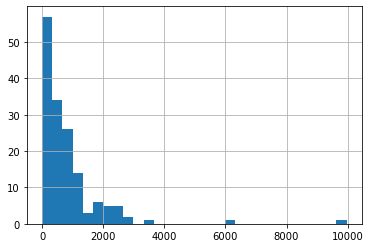

In [41]:
gdf_rome['n_shops'].hist(bins=30)

In [42]:
# there are two areas with very high number of shops

import numpy as np
gdf_rome[gdf_rome['n_shops'] >= np.quantile(gdf_rome['n_shops'], 0.99)]

,PRO_COM,COD_Z_URB,DEN_Z_URB,SHAPE_Leng,SHAPE_Area,geometry,n_traffic_lights,density_traffic_lights,n_shops
75,58091.0,1a,Centro Storico,9484.910322,3.204813e+06,"POLYGON ((788706.537 4645927.869, 788707.901 4...",41.0,12.793257,9965
79,58091.0,1e,Esquilino,8749.226658,3.092370e+06,"POLYGON ((789967.916 4644938.127, 789980.692 4...",43.0,13.905194,6124


In [44]:
# NaNs are areas where there are zero shops
gdf_rome['n_shops'] = gdf_rome['n_shops'].fillna(0)

# compute shops density for each area:
gdf_rome['density_shops'] = gdf_rome['n_shops'] / (gdf_rome['SHAPE_Area']*1e-6)

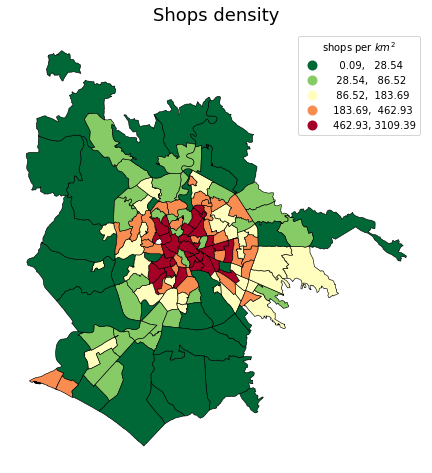

In [75]:
fig, ax = plt.subplots(1, figsize=(8,8))
gdf_rome.plot(ax=ax, column='density_shops', cmap='RdYlGn_r', edgecolor='black', linewidth=0.6,
              legend=True, legend_kwds={'title': r"shops per $km^2$"}, scheme='quantiles')


ax.set_title('Shops density', fontsize=18, pad=10)
ax.set_axis_off()

#fig = ax.get_figure()
#fig.savefig('rome_shop_density.png', dpi=300)

### Network features
There features are like
- network density
- edges’ betweenness centrality
- ratio of motorway roads

that can be computed from OpenStreetMap's data.

In [10]:
import osmnx as ox
import networkx as nx

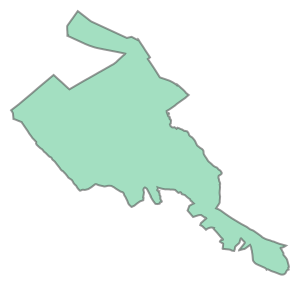

In [5]:
gdf_rome.iloc[0]['geometry']

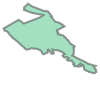

In [6]:
# reprojecting for getting the osm network
gdf_rome_4326 = gdf_rome.to_crs('epsg:4326')
gdf_rome_4326.iloc[0]['geometry']

In [7]:
G = ox.graph_from_polygon(gdf_rome_4326.iloc[0]['geometry'], network_type='drive_service')

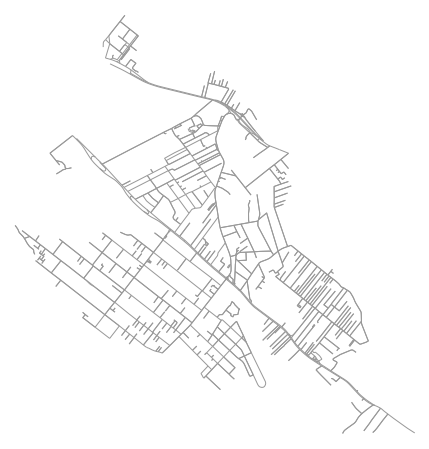

In [8]:
fig, ax = ox.plot_graph(G, bgcolor='w',node_size=0)

In [11]:
# compute betweenness centrality (directly on the original network, as there is a function for doing that)
edge_bcentrality = nx.edge_betweenness_centrality(G, normalized=True, weight='length')

In [14]:
# correct the resulting dictionary's keys
edge_bcentrality__corrected = {key: (edge_bcentrality[key[:-1]] if key[:-1] in edge_bcentrality.keys() else None)
                               for key in G.edges(keys=True)}

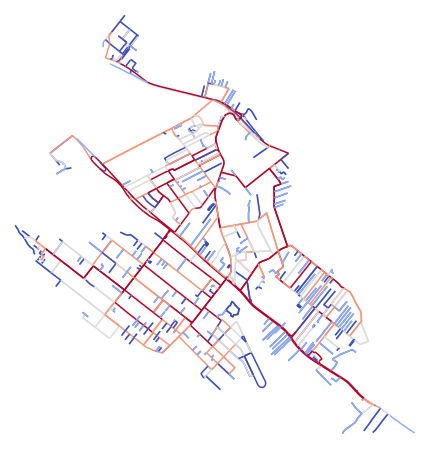

In [19]:
# get a color for each edge, by centrality, then plot the network with colored edges
ec = ox.plot.get_edge_colors_by_attr(G, 'betweenness_centrality', cmap='coolwarm', num_bins=5, equal_size=True)
fig, ax = ox.plot_graph(G, bgcolor='w', edge_color=ec, edge_linewidth=1.5, node_size=0)

In [ ]:
## TODO: compute the average (?) centrality of edges in the area

### Mapparoma's features
These features are the ones we get directly from the [#mapparoma project's open data](https://www.mapparoma.info/open-data/), like
- public transport accessibility
- nmber of car accidents
- population density